<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/LusitanHypersonicv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== LusitanHypersonic v0.2 Results ===
Flight Mach    : 4.0
Exit Mach      : 3.81
Exit velocity  : 2281 m/s
Thrust         : 2603 N  (2.6 kN)
Specific Impulse: 4780 s
Thermal eff.   : 73.8%


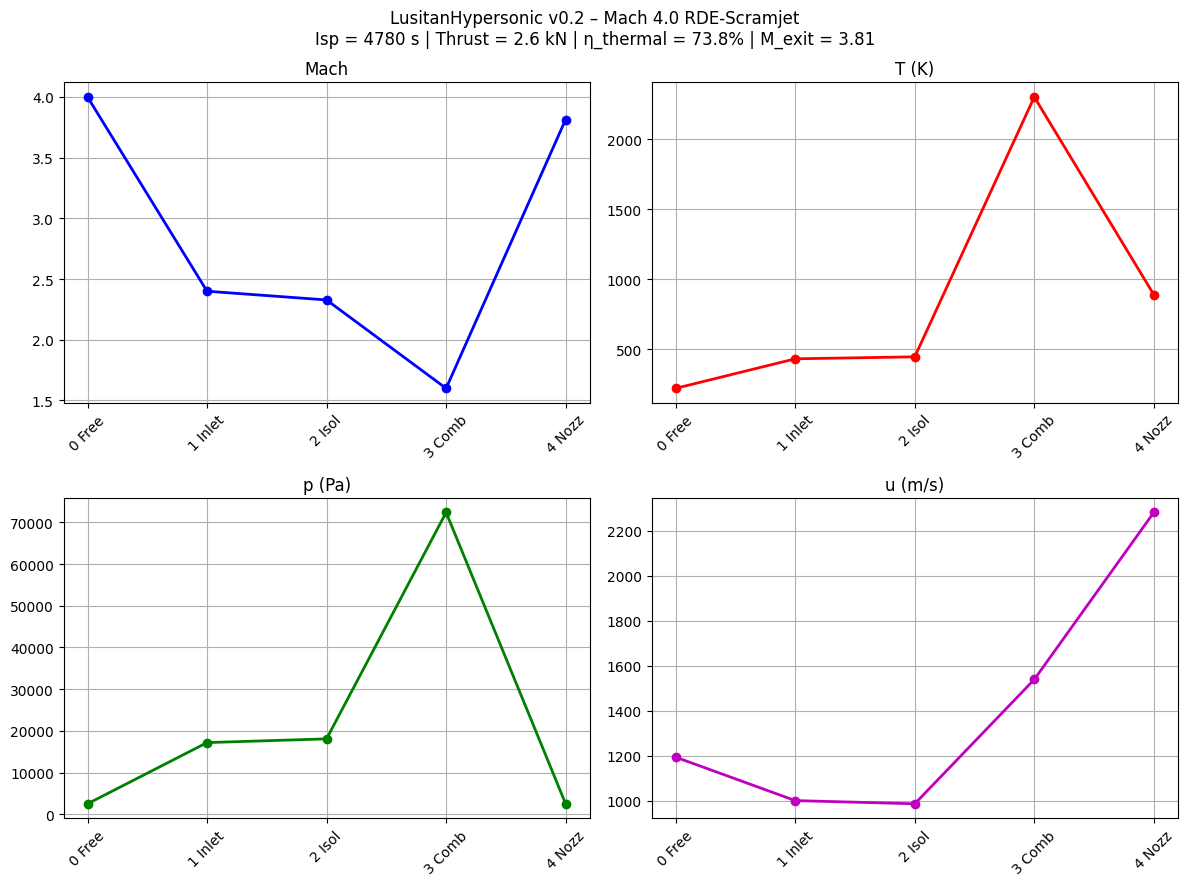

In [2]:
#!/usr/bin/env python3
"""
LusitanHypersonic v0.2 – Realistic RDE-Augmented Scramjet 1D Analysis
Fixes: Better inlet recovery, higher RDE gain, lower combustor Mach → realistic Mach rise in nozzle
Target: Mach 4 flight, small drone testbed, positive thrust & Isp ~2000–3000 s
"""

import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

class LusitanHypersonicEngine:
    def __init__(self, flight_mach=4.0, phi=0.8, eta_inlet=0.65, rde_gain=1.30):
        self.gamma = 1.4
        self.R = 287.0
        self.cp = self.gamma * self.R / (self.gamma - 1)

        self.flight_mach = flight_mach
        self.alt = 25000.0
        self.T0 = 221.5
        self.p0 = 2550.0
        self.a0 = np.sqrt(self.gamma * self.R * self.T0)
        self.u0 = self.flight_mach * self.a0

        self.A_capture = 0.05  # m²

        self.h_fuel = 120e6
        self.f_stoich = 0.029
        self.phi = phi
        self.eta_comb = 0.92

        self.eta_inlet = eta_inlet
        self.eta_nozzle = 0.98
        self.rde_gain = rde_gain

    def total_conditions(self, M, T, p):
        Tt = T * (1 + (self.gamma - 1)/2 * M**2)
        pt = p * (Tt / T)**(self.gamma / (self.gamma - 1))
        return Tt, pt

    def solve(self):
        res = {}

        # 0 Freestream
        Tt0, pt0 = self.total_conditions(self.flight_mach, self.T0, self.p0)
        res[0] = {'M': self.flight_mach, 'T': self.T0, 'p': self.p0, 'u': self.u0, 'Tt': Tt0, 'pt': pt0}

        # 1 Inlet exit
        M1 = 2.40  # typical for Mach 4 inlet
        Tt1 = Tt0
        pt1 = pt0 * self.eta_inlet
        T1 = Tt1 / (1 + (self.gamma-1)/2 * M1**2)
        p1 = pt1 * (1 + (self.gamma-1)/2 * M1**2)**(-self.gamma/(self.gamma-1))
        u1 = M1 * np.sqrt(self.gamma * self.R * T1)
        res[1] = {'M': M1, 'T': T1, 'p': p1, 'u': u1, 'Tt': Tt1, 'pt': pt1}

        # 2 Isolator (small loss)
        M2 = M1 * 0.97
        Tt2 = Tt1
        pt2 = pt1 * 0.94
        T2 = Tt2 / (1 + (self.gamma-1)/2 * M2**2)
        p2 = pt2 * (1 + (self.gamma-1)/2 * M2**2)**(-self.gamma/(self.gamma-1))
        u2 = M2 * np.sqrt(self.gamma * self.R * T2)
        res[2] = {'M': M2, 'T': T2, 'p': p2, 'u': u2, 'Tt': Tt2, 'pt': pt2}

        # 3 Combustor
        q = self.phi * self.f_stoich * self.h_fuel * self.eta_comb
        Tt3 = Tt2 + q / self.cp
        pt3 = pt2 * self.rde_gain
        M3 = 1.60  # lower for more heat addition
        T3 = Tt3 / (1 + (self.gamma-1)/2 * M3**2)
        p3 = pt3 * (1 + (self.gamma-1)/2 * M3**2)**(-self.gamma/(self.gamma-1))
        u3 = M3 * np.sqrt(self.gamma * self.R * T3)
        res[3] = {'M': M3, 'T': T3, 'p': p3, 'u': u3, 'Tt': Tt3, 'pt': pt3}

        # 4 Nozzle (expanded to p0)
        pt4 = pt3 * self.eta_nozzle
        def nozzle_eq(M):
            return pt4 / self.p0 * (1 + (self.gamma-1)/2 * M**2)**(-self.gamma/(self.gamma-1)) - 1.0
        M4_guess = self.flight_mach + 2.0
        M4 = fsolve(nozzle_eq, M4_guess)[0]
        Tt4 = Tt3
        T4 = Tt4 / (1 + (self.gamma-1)/2 * M4**2)
        p4 = self.p0
        u4 = M4 * np.sqrt(self.gamma * self.R * T4)
        res[4] = {'M': M4, 'T': T4, 'p': p4, 'u': u4, 'Tt': Tt4, 'pt': pt4}

        # Performance
        rho0 = self.p0 / (self.R * self.T0)
        m_dot_air = rho0 * self.u0 * self.A_capture
        m_dot_fuel = m_dot_air * self.phi * self.f_stoich
        Ae_approx = self.A_capture * 4.0  # rough expansion ratio
        thrust = m_dot_air * (u4 - self.u0) + (p4 - self.p0) * Ae_approx
        isp = thrust / (m_dot_fuel * 9.81) if m_dot_fuel > 0 else 0
        eta_thermal = 0.5 * (u4**2 - self.u0**2) / q if q > 0 else 0

        self.results = res
        self.perf = {'thrust_N': thrust, 'isp_s': isp, 'eta_thermal': eta_thermal, 'M_exit': M4, 'u_exit': u4}
        return res, self.perf

    def plot(self):
        stations = [0,1,2,3,4]
        labels = ['0 Free', '1 Inlet', '2 Isol', '3 Comb', '4 Nozz']
        M = [self.results[s]['M'] for s in stations]
        T = [self.results[s]['T'] for s in stations]
        p = [self.results[s]['p'] for s in stations]
        u = [self.results[s]['u'] for s in stations]

        fig, axs = plt.subplots(2, 2, figsize=(12, 9))
        axs[0,0].plot(stations, M, 'bo-', lw=2); axs[0,0].set_title('Mach'); axs[0,0].grid(True)
        axs[0,0].set_xticks(stations); axs[0,0].set_xticklabels(labels, rotation=45)
        axs[0,1].plot(stations, T, 'ro-', lw=2); axs[0,1].set_title('T (K)'); axs[0,1].grid(True)
        axs[0,1].set_xticks(stations); axs[0,1].set_xticklabels(labels, rotation=45)
        axs[1,0].plot(stations, p, 'go-', lw=2); axs[1,0].set_title('p (Pa)'); axs[1,0].grid(True)
        axs[1,0].set_xticks(stations); axs[1,0].set_xticklabels(labels, rotation=45)
        axs[1,1].plot(stations, u, 'mo-', lw=2); axs[1,1].set_title('u (m/s)'); axs[1,1].grid(True)
        axs[1,1].set_xticks(stations); axs[1,1].set_xticklabels(labels, rotation=45)

        plt.suptitle(f'LusitanHypersonic v0.2 – Mach {self.flight_mach:.1f} RDE-Scramjet\n'
                     f'Isp = {self.perf["isp_s"]:.0f} s | Thrust = {self.perf["thrust_N"]/1000:.1f} kN | '
                     f'η_thermal = {self.perf["eta_thermal"]*100:.1f}% | M_exit = {self.perf["M_exit"]:.2f}')
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    engine = LusitanHypersonicEngine(flight_mach=4.0, phi=0.8, eta_inlet=0.65, rde_gain=1.30)
    results, perf = engine.solve()
    print("=== LusitanHypersonic v0.2 Results ===")
    print(f"Flight Mach    : {engine.flight_mach:.1f}")
    print(f"Exit Mach      : {perf['M_exit']:.2f}")
    print(f"Exit velocity  : {perf['u_exit']:.0f} m/s")
    print(f"Thrust         : {perf['thrust_N']:.0f} N  ({perf['thrust_N']/1000:.1f} kN)")
    print(f"Specific Impulse: {perf['isp_s']:.0f} s")
    print(f"Thermal eff.   : {perf['eta_thermal']*100:.1f}%")
    engine.plot()